## ThinkDSP

This notebook contains code examples from Chapter 9: Differentiation and Integration

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Difference

As the first example, let's look at the Facebook data again.

In [3]:
if not os.path.exists('FB_2.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv

In [4]:
import pandas as pd

df = pd.read_csv('FB_2.csv', header = 0, parse_dates = [0])
len(df)

1977

In [5]:
from thinkdsp import Wave

ys = df['Close']
if len(ys) % 2: ys = ys[:-1]
close = Wave(ys, framerate = 1)
len(close)

1976

Here's what the time series looks like (ignoring the gaps between trading days).

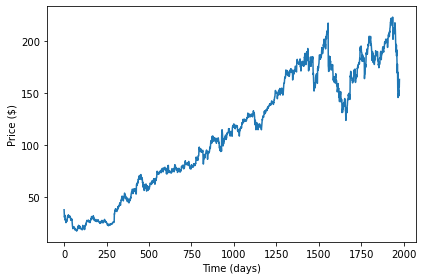

In [6]:
close.plot()
decorate(xlabel = 'Time (days)', ylabel = 'Price ($)')

And here's the spectrum on a log-log scale.

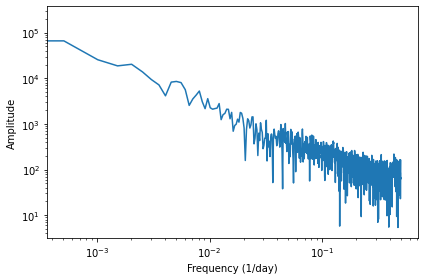

In [7]:
close_spectrum = close.make_spectrum()
close_spectrum.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude', xscale = 'log', yscale = 'log')

The slope of the power spectrum is -1.86, which is similar to red noise (which should have a slope of -2).

In [8]:
close_spectrum.estimate_slope().slope

-1.7895322348034641

We can use `np.diff` to compute the difference between successive elements, which is the daily change.

1975

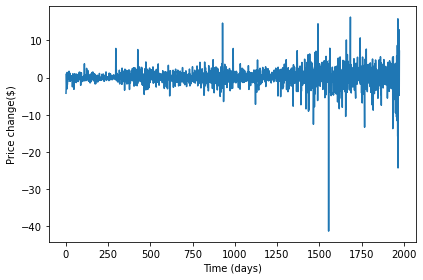

In [9]:
change = Wave(np.diff(close.ys), framerate = 1)
change.plot()
decorate(xlabel = 'Time (days)', ylabel = 'Price change($)')
len(change)

And here's the spectrum of the daily changes:

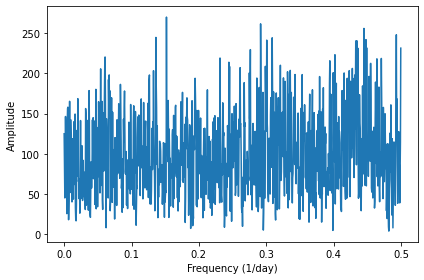

In [10]:
change_spectrum = change.make_spectrum()
change_spectrum.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude')

Recall that the spectrum of white noise looks like white noise.
Here's the spectrum on a log-log scale.

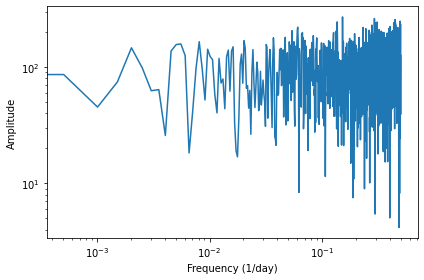

In [11]:
change_spectrum.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude', xscale = 'log', yscale = 'log')

The estimated slope is close to zero, which is consistent with white noise.

In [12]:
change_spectrum.estimate_slope().slope

0.09137404305435812

We can think the diff operation as convolution with a difference window, [1, -1].
And convolution with this window corresponds to multiplication by a filter.
The following function computes the filter that corresponds to the window.

In [13]:
from thinkdsp import zero_pad

def make_filter(window, wave):
    padded = zero_pad(window, len(wave))
    window_wave = Wave(padded, framerate = wave.framerate)
    window_spectrum = window_wave.make_spectrum()
    return window_spectrum

And here's what the filter looks like for the difference window:

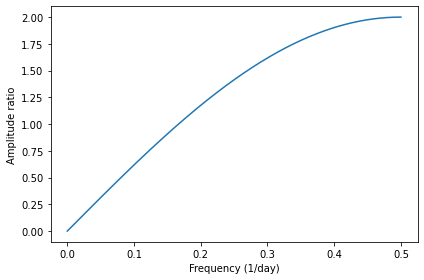

In [14]:
diff_window = np.array([1.0, -1.0])
diff_filter = make_filter(diff_window, close)
diff_filter.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude ratio')

And the angles:

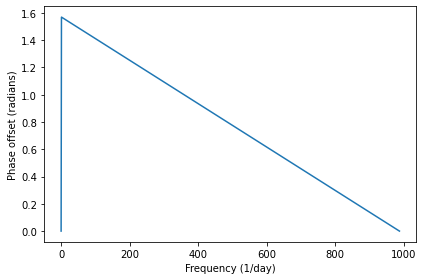

In [15]:
plt.plot(diff_filter.angles)
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Phase offset (radians)')

So we could also compute the daily changes by multiplying the spectrum of closing prices by the diff filter:

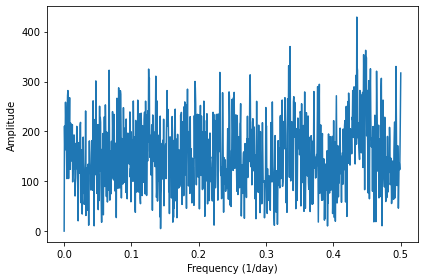

In [16]:
change_spectrum2 = close_spectrum * diff_filter
change_spectrum2.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude')

And then converting the spectrum to a wave.

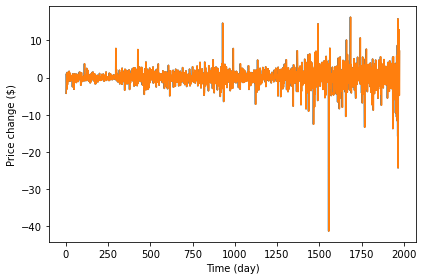

In [17]:
change2 = change_spectrum2.make_wave()
change2.ys = change2.ys[1:]
change2.ts = change2.ts[1:]
change.plot()
change2.plot()
decorate(xlabel = 'Time (day)', ylabel = 'Price change ($)')

Then we can confirm that we get the same result both ways (within floating point error).

In [18]:
change.max_diff(change2)

1.2390088954816747e-13

### Differentiation

This diff operation is an approximation of differentiation, and we can compute the filter for differentiation analytically: each complex component is multiplied by $2 \pi i f$.

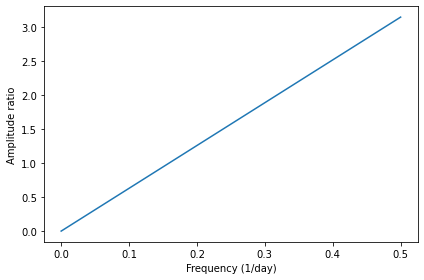

In [19]:
PI2 = np.pi * 2
deriv_filter = close.make_spectrum()
deriv_filter.hs = PI2 * 1j * deriv_filter.fs
deriv_filter.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude ratio')

Now we can apply the derivative filter to the spectrum of closing prices:

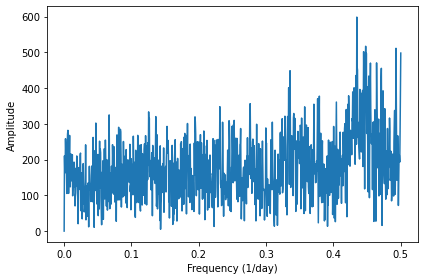

In [20]:
deriv_spectrum = close.make_spectrum().differentiate()
deriv_spectrum.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude')

The results are similar to what we got from `np.diff`, with some differences due to (1) the difference window is only a coarse approximation of the derivative, especially at higher frequencies, and (2) the spectral derivative is based on the assumption that the signal is periodic, so the behavior at the beginning and end is different.

In [21]:
deriv = deriv_spectrum.make_wave()
len(deriv), len(change)

(1976, 1975)

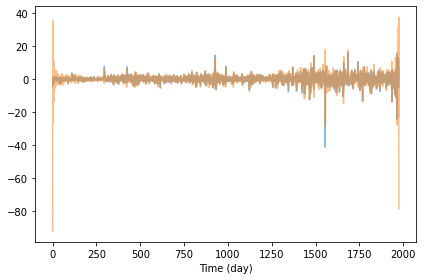

In [22]:
deriv = deriv_spectrum.make_wave()
change.plot(alpha = 0.5)
deriv.plot(alpha = 0.5)
decorate(xlabel = 'Time (day)')

We can see the differences more clearly by zooming in on a slice:

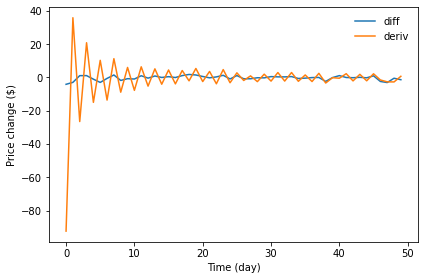

In [23]:
low, high = 0, 50
plt.plot(change.ys[low:high], label = 'diff')
plt.plot(deriv.ys[low:high], label = 'deriv')
decorate(xlabel = 'Time (day)', ylabel = 'Price change ($)')

The diffs and the spectral derivative are similar in many places, but sometimes substantially different.

Here's the difference between the derivative filter and the difference filter:

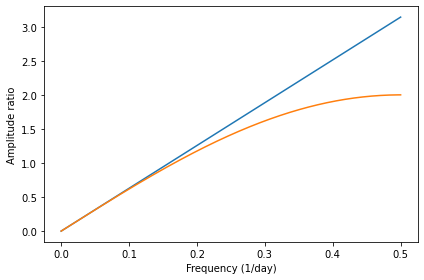

In [24]:
deriv_filter.plot()
diff_filter.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude ratio')

The difference filter does not amplify the highest frequencies as much, which is why the diffs are smoother than the derivative.

## Integration

Now let's think about integration.  We can compute the filter for integration analytically: each frequency component gets divided by $2 \pi i f$.
I plot the result on a log-y scale so we can see it more clearly.

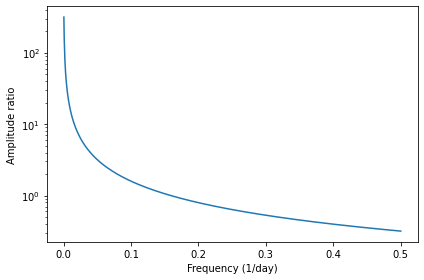

In [25]:
integ_filter = deriv_filter.copy()
integ_filter.hs[1:] = 1 / (PI2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf
integ_filter.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude ratio', yscale = 'log')

We can confirm that the integration filter is correct by applying it to the spectrum of the derivative we just computed:

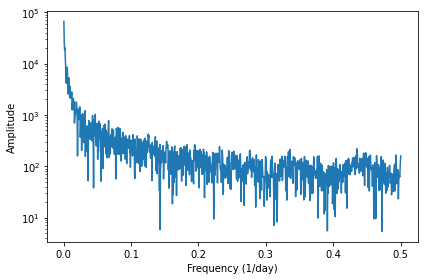

In [26]:
integ_spectrum = deriv_spectrum.copy().integrate()
integ_spectrum.plot()
decorate(xlabel = 'Frequency (1/day)', ylabel = 'Amplitude', yscale = 'log')

And then converting back to a wave.  The result is identical to the daily closing prices we started with, but shifted so the mean is 0.  
The reason the mean is 0 is that the derivative clobbers the first element of the spectrum, which is the bias.  Once the bias information is lost, integration can't restore it.  So the result has an unspecified constant of integration.

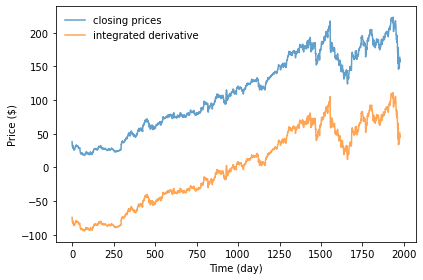

In [27]:
close.plot(label = 'closing prices', alpha = 0.7)
integ_spectrum.hs[0] = 0
integ_wave = integ_spectrum.make_wave()
integ_wave.plot(label = 'integrated derivative', alpha = 0.7)
decorate(xlabel = 'Time (day)', ylabel = 'Price ($)')

In [28]:
shift = np.mean(close.ys) - np.mean(integ_wave.ys)
diff = integ_wave.ys - close.ys + shift
np.max(np.abs(diff))

9.947598300641403e-14

### Cumulative sum

In the same way that the diff operator approximates differentiation, the cumulative sum approximates integration.
We'll demonstrate with a Sawtooth signal.

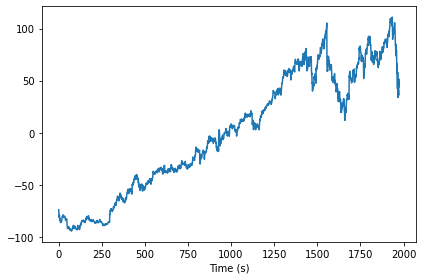

In [78]:
from thinkdsp import SawtoothSignal

in_wave = close
#SawtoothSignal(freq = 50).make_wave(duration = 0.1, framerate = 44100)
in_wave.unbias()
in_wave.plot()
decorate(xlabel = 'Time (s)')

Here's the spectrum before the cumulative sum:

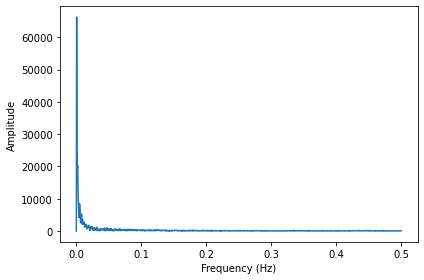

In [79]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude')

The output wave is the cumulative sum of the input

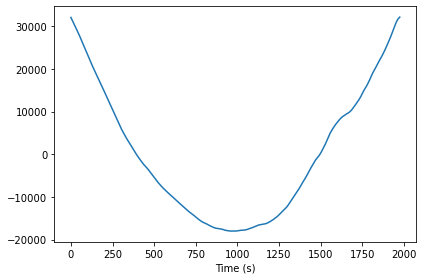

In [80]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel = 'Time (s)')

And here's its spectrum:

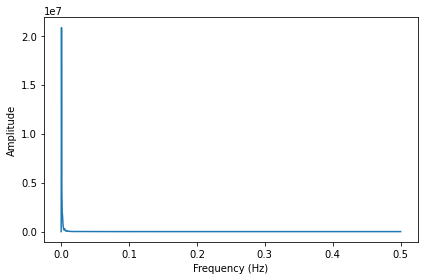

In [81]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude')

Now we compute the ratio of the output to the input:

In [82]:
sum(in_spectrum.amps < 1), len(in_spectrum)

(1, 989)

In between the harmonics, the input componenents are small, so We set those ratios to NaN.

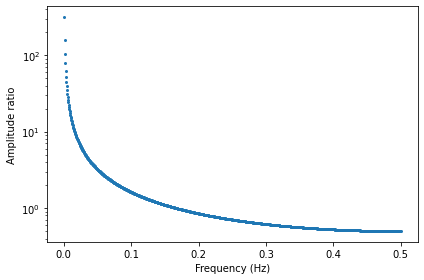

In [83]:
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh = 1)
ratio_spectrum.plot(marker = '.', ms = 4, ls = '')
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude ratio', yscale = 'log')

To get the cumsum filter, We compute the diff filter again and invert it.

In [84]:
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate = in_wave.framerate)
diff_filter = diff_wave.make_spectrum()

In [85]:
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf

In [86]:
integ_filter = cumsum_filter.copy()
integ_filter.hs[1:] = integ_filter.framerate / (PI2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

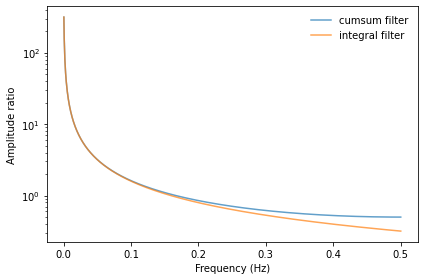

In [87]:
cumsum_filter.plot(label = 'cumsum filter', alpha = 0.7)
integ_filter.plot(label = 'integral filter', alpha = 0.7)
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude ratio', yscale = 'log')

Finally, we can compare the computed ratios to the filter.  They match, confirming that the cumsum filter is the inverse of the diff filter.

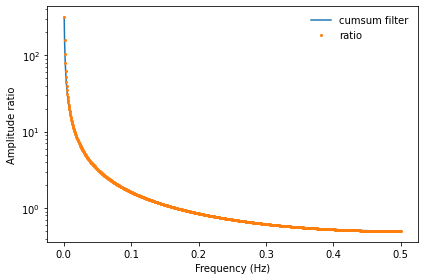

In [88]:
cumsum_filter.plot(label = 'cumsum filter')
ratio_spectrum.plot(label = 'ratio', marker = '.', ms = 4, ls = '')
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude ratio', yscale = 'log')

Now we can compute the output wave using the convolution theorem, and compare the results:

In [89]:
len(in_spectrum), len(cumsum_filter)

(989, 989)

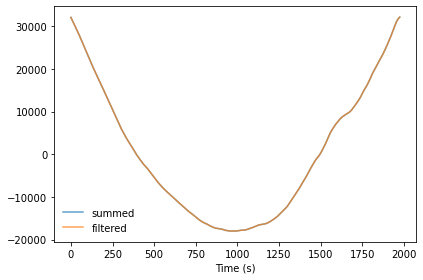

In [90]:
out_wave.plot(label = 'summed', alpha = 0.7)
cumsum_filter.hs[0] = 0
out_wave2 = (in_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label = 'filtered', alpha = 0.7)
decorate(xlabel = 'Time (s)')

They are the same, within floating point error.

In [91]:
out_wave.max_diff(out_wave2)

1.6416379367001355e-10

## Exercise 2

The goal of this exercise is to explore the effect of `diff` and `differentiate` on a signal.  Create a triangle wave and plot it.  Apply the `diff` operator and plot the result.  Compute the spectrum of the triangle wave, apply `differentiate`, and plot the result.  Convert the spectrum back to a wave and plot it.  Are there differences between the effect of `diff` and `differentiate` for this wave?

Here's the triangle wave.

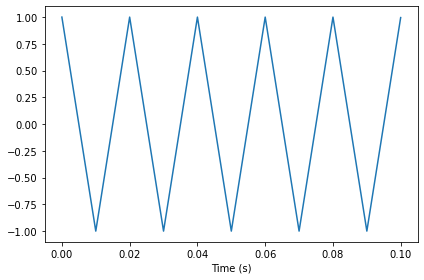

In [43]:
from thinkdsp import TriangleSignal

in_wave = TriangleSignal(freq = 50).make_wave(duration = 0.1, framerate = 44100)
in_wave.plot()
decorate(xlabel = 'Time (s)')

The diff of a triangle wave is a square wave, which explains why the harmonics in a square wave drop off like $1/f$, compared to the triangle wave, which drops off like $1/f^2$.

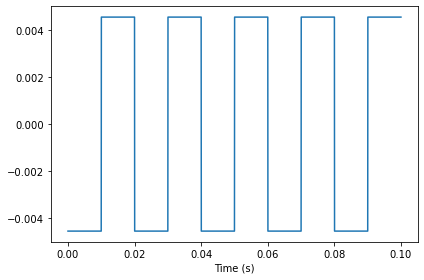

In [44]:
out_wave = in_wave.diff()
out_wave.plot()
decorate(xlabel = 'Time (s)')

When we take the spectral derivative, we get "ringing" around the discontinuities.
Mathematically speaking, the problem is that the derivative of the triangle wave is undefined at the points of the triangle.

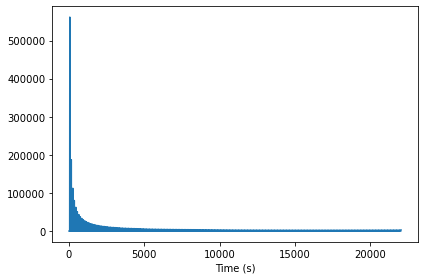

In [45]:
out_result = in_wave.make_spectrum().differentiate()
out_result.plot()
decorate(xlabel = 'Time (s)')

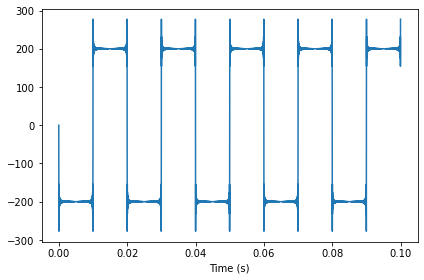

In [46]:
out_wave2 = out_result.make_wave()
out_wave2.plot()
decorate(xlabel = 'Time (s)')

## Exercise 3

The goal of this exercise is to explore the effect of `cumsum` and `integrate` on a signal.  Create a square wave and plot it.  Apply the `cumsum` operator and plot the result.  Compute the spectrum of the square wave, apply `integrate`, and plot the result.  Convert the spectrum back to a wave and plot it.  Are there differences between the effect of `cumsum` and `integrate` for this wave?

Here's the square wave.

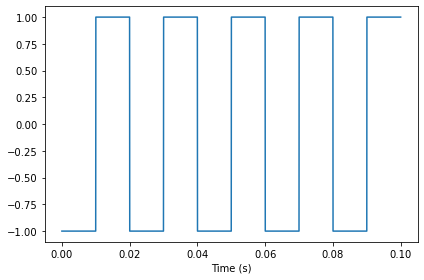

In [47]:
from thinkdsp import SquareSignal

in_wave = SquareSignal(freq = 50).make_wave(duration = 0.1, framerate = 44100)
in_wave.plot()
decorate(xlabel = 'Time (s)')

The cumulative sum of a square wave is a triangle wave.  After the previous exercise, that should come as no surprise.

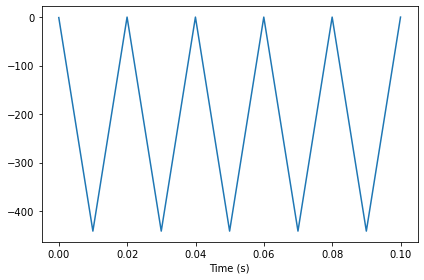

In [48]:
out_wave = in_wave.cumsum()
out_wave.plot()
decorate(xlabel = 'Time (s)')

The spectral integral is also a triangle wave, although the amplitude is very different.

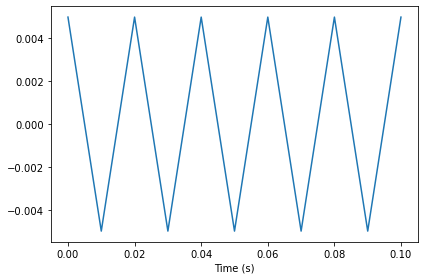

In [49]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel = 'Time (s)')

If we unbias and normalize the two waves, they are visually similar.

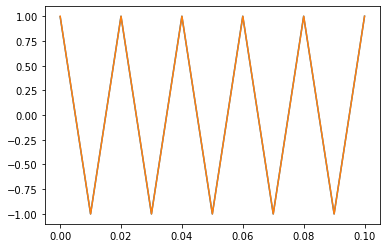

In [50]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()

And they are numerically similar, but with only about 3 digits of precision.

In [51]:
out_wave.max_diff(out_wave2)

0.0045351473922902175

## Exercise 4

The goal of this exercise is the explore the effect of integrating twice.  Create a sawtooth wave, compute its spectrum, then apply `integrate` twice.  Plot the resulting wave and its spectrum.  What is the mathematical form of the wave?  Why does it resemble a sinusoid? 

Here's the sawtooth.

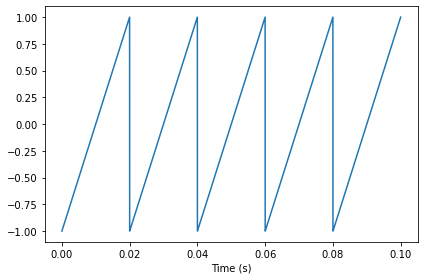

In [52]:
from thinkdsp import SawtoothSignal

in_wave = SawtoothSignal(freq = 50).make_wave(duration = 0.1, framerate = 44100)
in_wave.plot()
decorate(xlabel = 'Time (s)')

The first cumulative sum of a sawtooth is a parabola:

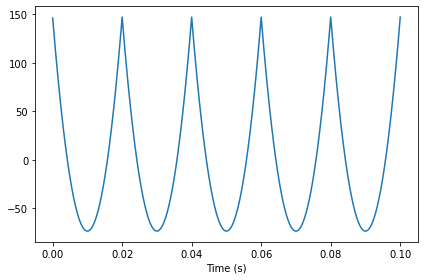

In [53]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel = 'Time (s)')

The second cumulative sum is a cubic curve:

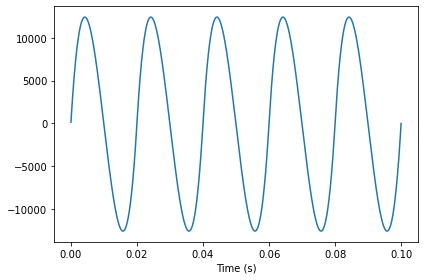

In [54]:
out_wave = out_wave.cumsum()
out_wave.plot()
decorate(xlabel = 'Time (s)')

Integrating twice also yields a cubic curve.

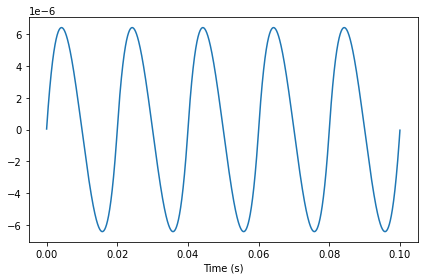

In [55]:
spectrum = (in_wave.make_spectrum().integrate()).integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel = 'Time (s)')

At this point, the result looks more and more like a sinusoid.  The reason is that integration acts like a low pass filter.  At this point we have filtered out almost everything except the fundamental, as shown in the spectrum below:

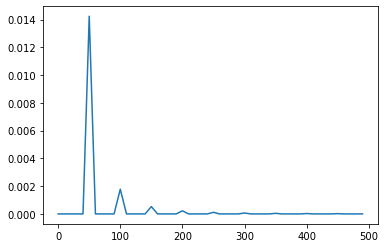

In [56]:
out_wave2.make_spectrum().plot(high = 500)

## Exercise 5

The goal of this exercise is to explore the effect of the 2nd difference and 2nd derivative.  Create a `CubicSignal`, which is defined in `thinkdsp`.  Compute the second difference by applying `diff` twice.  What does the result look like.  Compute the second derivative by applying `differentiate` twice.  Does the result look the same?

Plot the filters that corresponds to the 2nd difference and the 2nd derivative and compare them.  Hint: In order to get the filters on the same scale, use a wave with framerate 1.

Here's the cubic signal

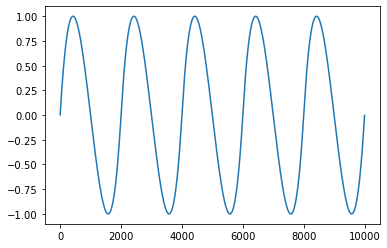

In [57]:
from thinkdsp import CubicSignal

in_wave = CubicSignal(freq = 0.0005).make_wave(duration = 10000, framerate = 1)
in_wave.plot()

The first difference is a parabola and the second difference is a sawtooth wave (no surprises so far):

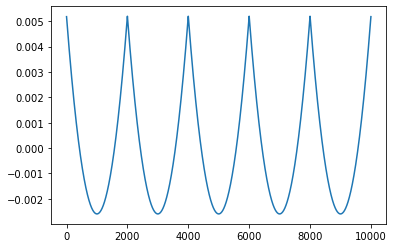

In [58]:
out_wave = in_wave.diff()
out_wave.plot()

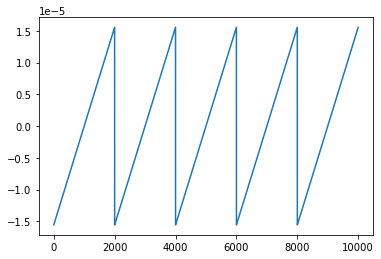

In [59]:
out_wave = out_wave.diff()
out_wave.plot()

When we differentiate twice, we get a sawtooth with some ringing.  Again, the problem is that the deriviative of the parabolic signal is undefined at the points.

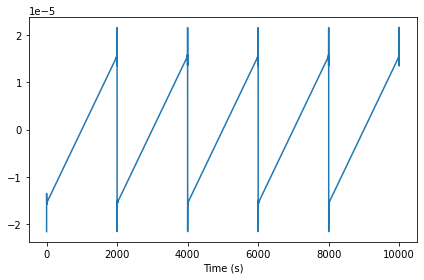

In [60]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel = 'Time (s)')

The window of the second difference is -1, 2, -1. By computing the DFT of the window, we can find the corresponding filter.

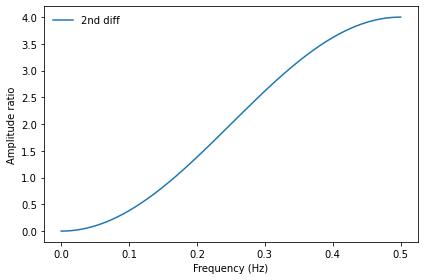

In [61]:
from thinkdsp import zero_pad, Wave

diff_window = np.array([-1.0, 2.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate = in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
diff_filter.plot(label = '2nd diff')
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude ratio')

And for the second derivative, we can find the corresponding filter by computing the filter of the first derivative and squaring it.

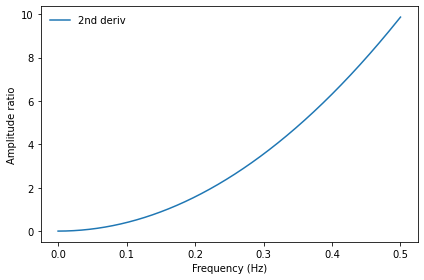

In [62]:
deriv_filter = in_wave.make_spectrum()
deriv_filter.hs = (np.pi * 2 * 1j * deriv_filter.fs) ** 2
deriv_filter.plot(label = '2nd deriv')
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude ratio')

Here's what the two filters look like on the same scale:

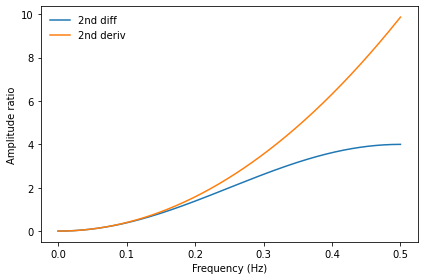

In [63]:
diff_filter.plot(label = '2nd diff')
deriv_filter.plot(label = '2nd deriv')
decorate(xlabel = 'Frequency (Hz)', ylabel = 'Amplitude ratio')

Both are high pass filters that amplify the highest frequency components. The 2nd derivative is parabolic, so it amplifies the highest frequencies the most. The 2nd difference is a good approximation of the 2nd derivative only at the lowest frequencies, then it deviates substantially.